# Snow Density Calculations

This notebook demonstrates methods for calculating density from common snow pit measurements (hand hardness and grain form) using the "Geldsetzer" method for calculating density. The analysis the local snowpyt_mechparams package and snowpylot for CAAML parsing.


In [20]:
# Import Libraries
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import snowpylot for CAAML parsing
from snowpylot import caaml_parser

# Add the src directory to the path to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import convert_grain_form
from snowpyt_mechparams import density


Parse Snowpit Files

In [13]:
all_pits = []
failed_files = []

folder_path = 'data'

xml_files = [f for f in os.listdir(folder_path) if f.endswith('.xml')]

for file in xml_files:
    try:
        file_path = os.path.join(folder_path, file)
        pit = caaml_parser(file_path)
        all_pits.append(pit)
    except Exception as e:
        failed_files.append((file, str(e)))
        print(f"Warning: Failed to parse {file}: {e}")

print(f"Successfully parsed {len(all_pits)} files")
print(f"Failed to parse {len(failed_files)} files")


Successfully parsed 50278 files
Failed to parse 0 files


Collect relevant data for each pit and convert to form needed to implement Geldsetzer

In [14]:
# Collect relevant data from each snowpit
pit_info = []
layer_info = []

for pit in all_pits:
    pit_dict = {
        'pit_id': pit.core_info.pit_id,
        'layer_count': len(pit.snow_profile.layers),
    }
    pit_info.append(pit_dict)

    for layer in pit.snow_profile.layers:
        # Create base layer dictionary
        layer_dict = {
            'pit_id': pit.core_info.pit_id,
            'hand_hardness': layer.hardness,
            'grain_form_primary': layer.grain_form_primary,
        }

        # Add geldsetzer grain form conversion if grain form data exists
        if layer.grain_form_primary:
            layer_dict['geldsetzer_grain_form'] = convert_grain_form(layer.grain_form_primary, 'geldsetzer')
        else:
            layer_dict['geldsetzer_grain_form'] = None

        layer_info.append(layer_dict)

# Create a dataframe from the pit and layer info
pit_df = pd.DataFrame(pit_info)
layer_df = pd.DataFrame(layer_info)


Implement Geldsetzer Method

In [15]:
# Calculate density using Geldsetzer method for each layer
def calculate_layer_density(row):
    try:
        # Only calculate if we have a mapped grain form and hand hardness
        if pd.isna(row['geldsetzer_grain_form']) and pd.isna(row['hand_hardness']):
            return pd.Series([np.nan, np.nan])

        # The density function returns a ufloat object with nominal value and uncertainty
        density_ufloat = density.calculate_density(
            method='geldsetzer',
            hand_hardness=row['hand_hardness'],
            grain_form=row['geldsetzer_grain_form']
        )

        # Extract nominal value and standard deviation from ufloat object
        density_val = density_ufloat.nominal_value  # or density_ufloat.n
        density_unc = density_ufloat.std_dev        # or density_ufloat.s

        return pd.Series([density_val, density_unc])
    except Exception as e:
        print(f"Error calculating density for layer {row['pit_id']}: {e}")
        return pd.Series([np.nan, np.nan])

# Add density and uncertainty columns to the dataframe using apply method
# Calculate density for all rows - the function handles missing data internally
layer_df[['density', 'total_uncertainty']] = layer_df.apply(calculate_layer_density, axis=1)

# Calculate relative uncertainty
layer_df['relative_uncertainty'] = (layer_df['total_uncertainty'] / layer_df['density']) * 100


In [ ]:
#layer_df.to_csv('geldsetzer_density_results.csv', index=False)


In [24]:
## Summary Stats

# Calculate and display summary statistics
print("=== GELDSETZER DENSITY APPLICATION SUMMARY ===")
print()

# Total Pits
total_pits = layer_df['pit_id'].nunique()
print(f"Total Pits: {total_pits:,}")

# Total Layers
total_layers = len(layer_df)
print(f"Total Layers: {total_layers:,}")

# Total Layers with Hand Hardness and Grain Form Info
# Check for layers that have both hand hardness and grain form data
layers_with_data = layer_df[(layer_df['hand_hardness'].notna()) & 
                           (layer_df['grain_form_primary'].notna())]
total_layers_with_data = len(layers_with_data)
print(f"Total Layers with Hand Hardness and Grain Form Info: {total_layers_with_data:,}, "
      f"{total_layers_with_data/total_layers*100:.1f}%")

# Total Layers with Successfully Calculated Density
layers_with_density = layer_df[layer_df['density'].notna()]
total_successful_density = len(layers_with_density)
print(f"Total Layers with Successfully Calculated Density (YIELD?): {total_successful_density:,}, "
      f"{total_successful_density/total_layers*100:.1f}%")

# Average Relative Uncertainty
avg_relative_uncertainty = layer_df['relative_uncertainty'].mean()
print(f"Average Relative Uncertainty: {avg_relative_uncertainty:.2f}%")


=== GELDSETZER DENSITY APPLICATION SUMMARY ===

Total Pits: 50,147
Total Layers: 371,429
Total Layers with Hand Hardness and Grain Form Info: 279,331, 75.2%
Total Layers with Successfully Calculated Density (YIELD?): 200,676, 54.0%
Average Relative Uncertainty: 22.30%


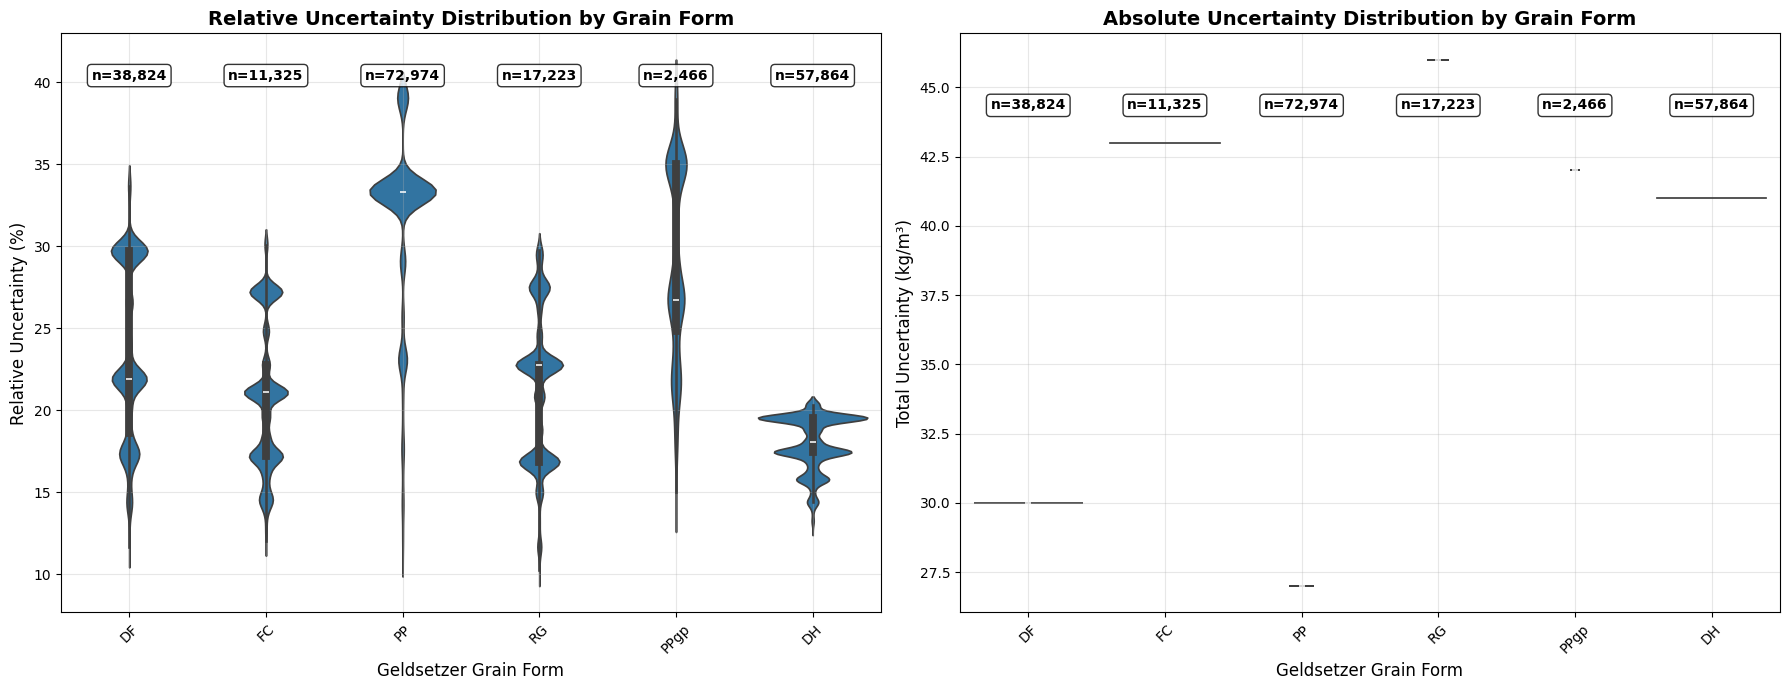


=== UNCERTAINTY BY GRAIN FORM SUMMARY ===
                       Sample_Count  Mean_Rel_Uncertainty_%  \
geldsetzer_grain_form                                         
DF                            38824                   23.38   
DH                            11325                   18.00   
FC                            72974                   20.73   
PP                            17223                   31.65   
PPgp                           2466                   28.99   
RG                            57864                   21.35   

                       Median_Rel_Uncertainty_%  StdDev_Rel_Uncertainty_%  \
geldsetzer_grain_form                                                       
DF                                        21.90                      5.26   
DH                                        18.08                      1.64   
FC                                        21.08                      4.32   
PP                                        33.33                    

In [22]:
# Grain form vs uncertainty
# Filter data to only include successful density calculations
density_data = layer_df[layer_df['density'].notna()].copy()

# Remove any rows where grain form is None/NaN
density_data = density_data[density_data['geldsetzer_grain_form'].notna()]

# Calculate sample sizes for each grain form
sample_sizes = density_data.groupby('geldsetzer_grain_form').size()

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Violin plot showing relative uncertainty distribution by grain form
sns.violinplot(data=density_data, x='geldsetzer_grain_form', y='relative_uncertainty', ax=ax1, inner='box')
ax1.set_title('Relative Uncertainty Distribution by Grain Form', fontsize=14, fontweight='bold')
ax1.set_xlabel('Geldsetzer Grain Form', fontsize=12)
ax1.set_ylabel('Relative Uncertainty (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add sample size annotations to first plot
for i, grain_form in enumerate(sample_sizes.index):
    count = sample_sizes[grain_form]
    ax1.text(i, ax1.get_ylim()[1] * 0.95, f'n={count:,}', 
             ha='center', va='top', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Violin plot showing absolute uncertainty distribution by grain form
sns.violinplot(data=density_data, x='geldsetzer_grain_form', y='total_uncertainty', ax=ax2, inner='box')
ax2.set_title('Absolute Uncertainty Distribution by Grain Form', fontsize=14, fontweight='bold')
ax2.set_xlabel('Geldsetzer Grain Form', fontsize=12)
ax2.set_ylabel('Total Uncertainty (kg/m³)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add sample size annotations to second plot
for i, grain_form in enumerate(sample_sizes.index):
    count = sample_sizes[grain_form]
    ax2.text(i, ax2.get_ylim()[1] * 0.95, f'n={count:,}', 
             ha='center', va='top', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics by grain form
print("\n=== UNCERTAINTY BY GRAIN FORM SUMMARY ===")
uncertainty_by_grain = density_data.groupby('geldsetzer_grain_form').agg({
    'relative_uncertainty': ['count', 'mean', 'median', 'std'],
    'total_uncertainty': ['mean', 'median', 'std']
}).round(2)

# Flatten column names
uncertainty_by_grain.columns = [f'{col[1]}_{col[0]}' if col[1] else col[0] for col in uncertainty_by_grain.columns]

# Rename columns for clarity
column_mapping = {
    'count_relative_uncertainty': 'Sample_Count',
    'mean_relative_uncertainty': 'Mean_Rel_Uncertainty_%',
    'median_relative_uncertainty': 'Median_Rel_Uncertainty_%', 
    'std_relative_uncertainty': 'StdDev_Rel_Uncertainty_%',
    'mean_total_uncertainty': 'Mean_Abs_Uncertainty_kg/m3',
    'median_total_uncertainty': 'Median_Abs_Uncertainty_kg/m3',
    'std_total_uncertainty': 'StdDev_Abs_Uncertainty_kg/m3'
}
uncertainty_by_grain = uncertainty_by_grain.rename(columns=column_mapping)

print(uncertainty_by_grain)
